In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 🤗 Datasets

In this notebook, it will be built a system to automatically identify purchases categories from their descriptions. The system will be built using the Datasets library.

Datasets is a lightweight and extensible library to easily share and access datasets and evaluation metrics for Natural Language Processing (NLP) and more. It will be a dataset provided by Meta Inc.

In [2]:
import json

labels = json.loads(open('data/lvl_1_labels.json').read())

# turn dict to array of labels ordered by id
names = [labels[str(i)] for i in range(len(labels))]
names

['Energy & Utilities',
 'Human Resources',
 'Logistics',
 'Manufacturing',
 'Professional Services',
 'R&D Equipment (incl. Equipment Services and Supplies)',
 'Real Estate & Facilities',
 'Sales, Marketing & Events',
 'Technology/Telecom',
 'Travel & Expense',
 'Uncategorized']

In [3]:
from datasets import load_dataset, DatasetDict, Features, Value, ClassLabel

# Define features
features = Features({
    'text': Value(dtype='string'),
    'label': ClassLabel(num_classes=(len(names)), names=names)
})

# Load dataset
data = load_dataset("data", "lvl_1_data", features=features)

# Split the dataset into train, validation, and test sets
train_testvalid = data["train"].train_test_split(test_size=0.3)       # Splitting train and test+validation
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)  # Splitting test and validation

# Create a new DatasetDict
data = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7885
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1690
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1690
    })
})

In [4]:
data["train"][:5]

{'text': ['Normalized Supplier Name, MOROTA PESCADOS LTDA, Country Name, Brazil, Strategic Region, NORAM, Requestor Name, Lisandro Ulerio, Preparer Name, Victória Simonato, Business Unit, Facilities, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), Non-Bay Area Facilities & Operations Group, Cost Center (Level 4), FCS G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Kitchen, Invoice Source, CAFEPRO, GL Description, Kitchen, Project, 31311 - Sao Paolo Aguas de Marco',
  'Normalized Supplier Name, PATRIMONIOS AUTONOMOS FIDUCIARIA BOGOTA SA, Country Name, Colombia, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Facilities, Legal Entity, Facebook Colombia S.A.S., Cost Center (Base Level), Non-Bay Area Facilities & Operations Group, Cost Center (Level 4), FCS G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Prepaid Exp. & Other Current Assets, Invoice Source, RENT, GL De

In [5]:
data["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['Energy & Utilities', 'Human Resources', 'Logistics', 'Manufacturing', 'Professional Services', 'R&D Equipment (incl. Equipment Services and Supplies)', 'Real Estate & Facilities', 'Sales, Marketing & Events', 'Technology/Telecom', 'Travel & Expense', 'Uncategorized'], id=None)}

# 2. The model is only as good as its labels

In [6]:
data.set_format(type="pandas")
df = data["train"][:]
print(df.shape)
df.head()

(7885, 2)


,text,label
0,"Normalized Supplier Name, MOROTA PESCADOS LTDA...",6
1,"Normalized Supplier Name, PATRIMONIOS AUTONOMO...",6
2,"Normalized Supplier Name, BANCO DO BRASIL S A,...",4
3,"Normalized Supplier Name, BANCO DO BRASIL S A,...",4
4,"Normalized Supplier Name, EDELMAN, Country Nam...",4


In [7]:
df["label_name"] = df["label"].apply(lambda row: data["train"].features["label"].int2str(row))
df.head()

,text,label,label_name
0,"Normalized Supplier Name, MOROTA PESCADOS LTDA...",6,Real Estate & Facilities
1,"Normalized Supplier Name, PATRIMONIOS AUTONOMO...",6,Real Estate & Facilities
2,"Normalized Supplier Name, BANCO DO BRASIL S A,...",4,Professional Services
3,"Normalized Supplier Name, BANCO DO BRASIL S A,...",4,Professional Services
4,"Normalized Supplier Name, EDELMAN, Country Nam...",4,Professional Services


## 2.1 Class distribution

A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one.

In this case, the class distribution is skewed towards the `Professional Services` class, which is the most frequent one. There are several ways to deal with this issue, such as:

* randomly oversample the minority classes
* randomly undersample the majority classes
* gather more labeled data for the minority classes

For more advanced strategies, check out the [imbalanced-learn](https://imbalanced-learn.org/stable/) library.

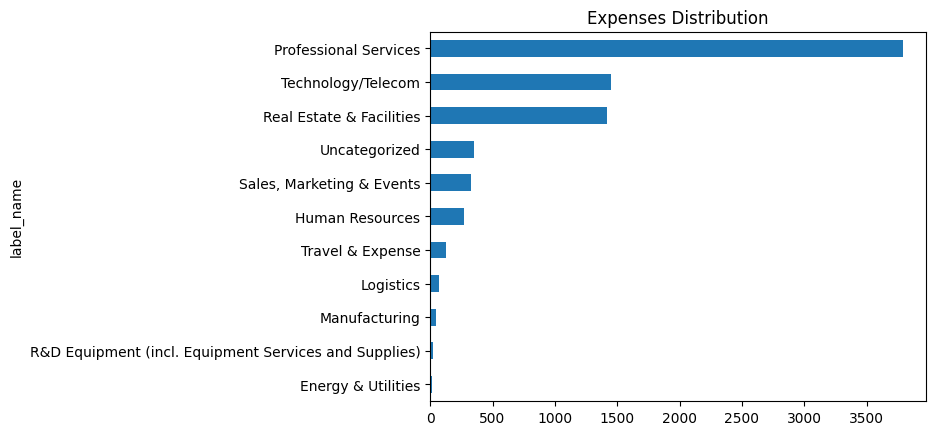

In [8]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Expenses Distribution")
plt.show();

## 2.2 How long are our sentences?

This classification will use **DistilBERT**, a variant of BERT that achieves comparable performance, while being significantly smaller and more efficient. This enables training a classifier in a few minutes. To train a larger BERT model, one can simply change the checkpoint of the pretrained model. A *checkpoint* corresponds to the set of weights that are loaded into a given transformer architecture.

For applications using DistilBERT, the maximum context size is 512 tokens. From the plot we see that for each emotion, most sentences are around 15 words long and the longest are well below DistilBERT's maximum context size.

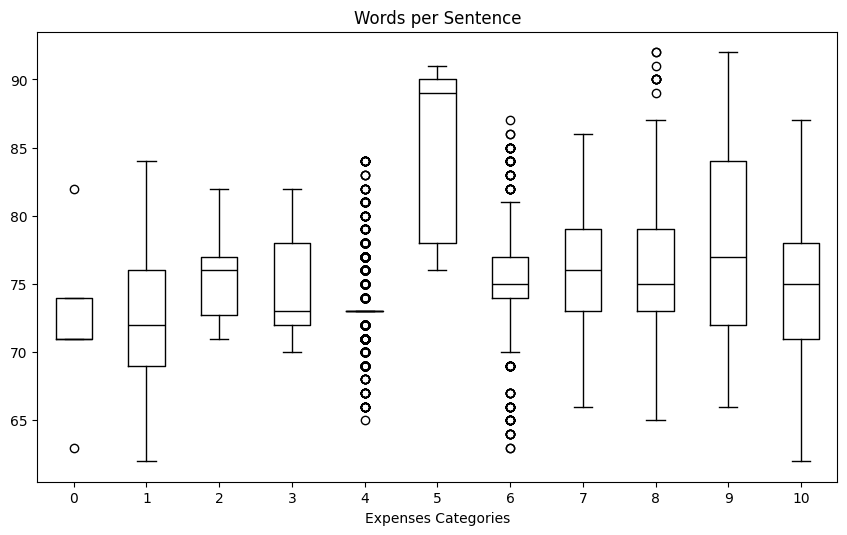

In [9]:
df["words_count"] = df["text"].str.split().apply(len)
df.boxplot(
  column="words_count",
  by="label",
  grid=False,
  showfliers=True,
  color="black", 
  figsize=(10, 6)
)
plt.title("Words per Sentence")
plt.suptitle("")
plt.xlabel("Expenses Categories")
plt.show();

In [10]:
data.reset_format()

# 3. From text to tokens

Transformer models cannot receive raw strings as input; instead, they assume the text has been *tokenized* and *encoded* as numerical vectors. There are several tokenization strategies and the optimal splitting of words into tokens is usually learned from the corpus. BERT and [DistilBERT](https://huggingface.co/distilbert-base-uncased) are pretrained models that were trained on subword tokenization using the WordPiece tokenizer algorithm.

**Important**: transformers expect each character to be converted to a number, a process called *numericalization*. The problem with this approach is that it creates a fictitious ordering between the names, and neural networks are *really* good at picking up such *statistical regularities* in the data. To avoid this, dummy variables are used to represent the categories in one-hot vectors. The downside then is that the model will have quadratic complexity with the size of the vocabulary.

🤗 Transformers provides a convenient `AutoTokenizer` class that allows one to quickly load the tokenizer associated with a pretrained model - by just calling its `from_pretrained()` method, providing the ID of a model on the Hub or a local file path.

In [11]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [12]:
# fields the model expects in its forward pass
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [13]:
text = "Tokenizing text is a core task of NLP."

encoded_text = tokenizer(text)
print("input_ids: ", encoded_text["input_ids"])
print("attention_mask: ", encoded_text["attention_mask"])

input_ids:  [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102]
attention_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [14]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text["input_ids"])
print("tokens: ", tokens)

tokens:  ['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [15]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

## 3.1 Tokenizing the whole dataset

In [16]:
# padding=True : pad to the longest sequence in the batch
# truncation=True : truncate to the model's maximum context size
# batched=True : encoding is done in batches
# batch_size=None : batch size is the full dataset as a single batch
#                   ensuring that input tensors and attention maks have the same shape


data_encoded = data.map(lambda batch: tokenizer(batch["text"], padding=True, truncation=True), batched=True, batch_size=None)
data_encoded

Map: 100%|██████████| 1690/1690 [00:00<00:00, 12598.22 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 7885
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1690
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1690
    })
})

In [17]:
data_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [18]:
example = data_encoded["train"][0]
tokens = tokenizer.convert_ids_to_tokens(example["input_ids"])

print("text: ", example["text"])
print("label: ", example["label"])
print("input_ids: ", example["input_ids"])
print("input_ids length: ", len(example["input_ids"]))
print("attention_mask: ", example["attention_mask"])
print("attention_mask length: ", len(example["attention_mask"]))
print("tokens: ", tokens)
print("tokenized text: ", tokenizer.convert_tokens_to_string(tokens))

text:  Normalized Supplier Name, MOROTA PESCADOS LTDA, Country Name, Brazil, Strategic Region, NORAM, Requestor Name, Lisandro Ulerio, Preparer Name, Victória Simonato, Business Unit, Facilities, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), Non-Bay Area Facilities & Operations Group, Cost Center (Level 4), FCS G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Kitchen, Invoice Source, CAFEPRO, GL Description, Kitchen, Project, 31311 - Sao Paolo Aguas de Marco
label:  6
input_ids:  [101, 3671, 3550, 17024, 2171, 1010, 22822, 17287, 21877, 15782, 12269, 5183, 2050, 1010, 2406, 2171, 1010, 4380, 1010, 6143, 2555, 1010, 12306, 2213, 1010, 5227, 2953, 2171, 1010, 7059, 4859, 3217, 17359, 11124, 2080, 1010, 7374, 2099, 2171, 1010, 3848, 4079, 10610, 1010, 2449, 3131, 1010, 4128, 1010, 3423, 9178, 1010, 9130, 14262, 7903, 2891, 3784, 2079, 21133, 5183, 2050, 1010, 3465, 2415, 1006, 2918, 2504, 1007, 1010, 2512, 1011, 3016, 2181, 4128, 

# 4. Training a text classifier

**DistilBERT** is pretrained to predict masked words in a sequence of text. The pretrained model is architectured as a **encoder-based model**, composed of a stack of hidden layers transforming the input sequence into a sequence of hidden states. In order to use it for text classification, it needs to be combined with a custom classification layer.

## 4.1 Feature-based approach

The model's hidden states are used as features and a classifier is trained on top of them, without modifying the pretrained model. The advantage of this approach is that we can quickly train a shallow model, such as a neural classification layer or a random forest, which is specially convenient if GPUs are unavailable.

In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier.

### 4.1.1 Using pretrained models

The `AutoModel` class converts token encodings to embeddings, and then feed them through the encoder stack to return the hidden states, making it possible to extract these states from the corpus.

In [19]:
from transformers import AutoModel
import torch

# load DistilBERT checkpoint
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### 4.1.2 Extracting last hidden states

DistilBERT, like BERT, uses a hidden size of 768 dimensions, meaning that the internal representations of words and tokens in the model have a dimensionality of 768.

The hidden size in a transformer-based model like BERT or DistilBERT determines the dimension of the model's embeddings and the dimension of the hidden states as the model processes input data. A higher hidden size allows the model to capture more complex patterns and relationships in the data but also makes the model larger and more computationally intensive.

For classification tasks, it is common practice to just use the hidden state corresponding to the first token of the input sequence, which is the special token [CLS] (for classification). This is because the hidden state of this token has access to the entire sequence through the attention mechanism.This means that during pre-training and fine-tuning, the model has learned to aggregate information from all tokens in the input sequence into this [CLS] token's hidden state.

#### 4.1.2.1 Last hidden state for a single string

In [20]:
# encode a string and convert tokens to PyTorch tensor
# expected tensor: [batch_size, n_tokens]
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
inputs, inputs["input_ids"].shape

({'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])},
 torch.Size([1, 6]))

In [21]:
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
tokens

['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']

In [22]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.inference_mode():
  outputs = model(**inputs)
outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)

In [23]:
# output shape: [batch_size, n_tokens, hidden_dims]
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

In [24]:
# hidden state corresponding to the first token of the input sequence [CLS]
outputs.last_hidden_state[:, 0].shape

torch.Size([1, 768])

#### 4.1.2.2 Last hidden state for whole dataset

In [25]:
def extract_hidden_states(batch):
  """"
  This function creates a hidden_state column in the batch
  by extracting the hidden state corresponding to the first token
  of the input sequence [CLS].
  """

  # move inputs to device
  inputs = { k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names }

  # extract last hidden states
  with torch.inference_mode():
    last_hidden_state = model(**inputs).last_hidden_state

  return { "hidden_state": last_hidden_state[:, 0].cpu().numpy() }

In [26]:
# model expects tensors as inputs
data_encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
data_encoded["train"][0]

{'label': tensor(6),
 'input_ids': tensor([  101,  3671,  3550, 17024,  2171,  1010, 22822, 17287, 21877, 15782,
         12269,  5183,  2050,  1010,  2406,  2171,  1010,  4380,  1010,  6143,
          2555,  1010, 12306,  2213,  1010,  5227,  2953,  2171,  1010,  7059,
          4859,  3217, 17359, 11124,  2080,  1010,  7374,  2099,  2171,  1010,
          3848,  4079, 10610,  1010,  2449,  3131,  1010,  4128,  1010,  3423,
          9178,  1010,  9130, 14262,  7903,  2891,  3784,  2079, 21133,  5183,
          2050,  1010,  3465,  2415,  1006,  2918,  2504,  1007,  1010,  2512,
          1011,  3016,  2181,  4128,  1004,  3136,  2177,  1010,  3465,  2415,
          1006,  2504,  1018,  1007,  1010,  4429,  2015,  1043,  1004,  1037,
          1010,  3465,  2415,  1006,  2504,  1019,  1007,  1010,  2236,  1004,
          3831,  1010,  1043,  2140,  4078,  2278,  1006,  2504,  1018,  1007,
          1010,  3829,  1010,  1999,  6767,  6610,  3120,  1010,  7668, 21572,
          1010,  1

In [27]:
data_hidden = data_encoded.map(extract_hidden_states, batched=True)

Map: 100%|██████████| 1690/1690 [00:49<00:00, 34.28 examples/s]


In [28]:
data["train"].column_names

['text', 'label']

### 4.1.3 Creating a feature matrix

After obtaining the hidden state associated with each sentence, the preprocessed dataset now contains all the information required to train a classifier on it. The hidden states will be used as input features and the labels as targets.

In [29]:
X_train = np.array(data_hidden["train"]["hidden_state"])
X_valid = np.array(data_hidden["validation"]["hidden_state"])
y_train = np.array(data_hidden["train"]["label"])
y_valid = np.array(data_hidden["validation"]["label"])
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((7885, 768), (1690, 768), (7885,), (1690,))

### 4.1.4 Training a simple classifier

The accuracy of the model is 0.633, which is quite good, considering that it deals with an unbalanced multiclass dataset. 

To examine the model's performance in more detail, it can be used the `DummyClassifier` class from scikit-learn to train a classifier that always predicts the most frequent class in the training set. This will provide a baseline to compare the model's performance against.

In [34]:
from sklearn.linear_model import LogisticRegression

# we increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.8952662721893491

In [35]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.48520710059171596

The confusion matrix tells the relationship between the true and predicted labels.

We can see that `anger` and `fear` are most often confused with `sadness`, which agrees with the observation we made when visualizing the embeddings. Also, `love` and `surprise` are frequently mistaken for `joy`.

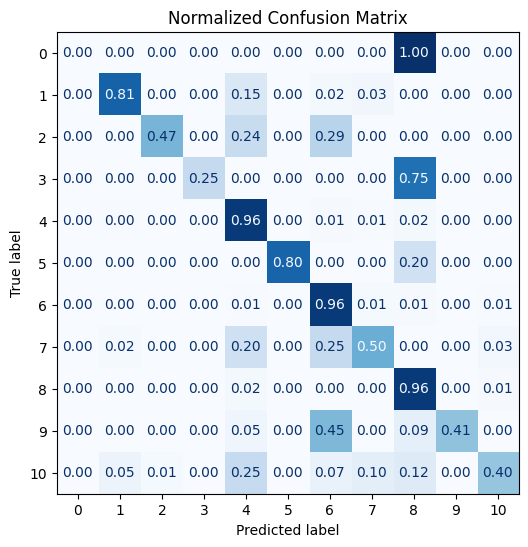

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  plt.show();

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels=[idx for idx, label in enumerate(labels)])

## 4.2 Fine-tuning approach

The whole model is trained end-to-end, updating all parameters of the pretrained model. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.

Training the hidden states that serve as inputs to the classification model will help to avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

### 4.2.1 Loading a pretrained model

The `AutoModelForSequenceClassification` class automatically loads the correct classification head for the model architecture, making it possible to load a pretrained model and fine-tune it on a new task in just a few lines of code. We just need to specify how many labels the model has to predict (6 in this case) and the model will automatically download the correct head and load it with the pretrained weights.

In [42]:
from transformers import AutoModelForSequenceClassification

num_labels = len(data["train"].features["label"].names)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2.2 Defining the performance metrics

In [43]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  """
  This function receives an `EvalPrediction` object (a namedtuple with a
  predictions and label_ids field) and returns a dictionary with the F1 
  score under the key `f1` and the accuracy under the key `accuracy`
  """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

### 4.2.3 Training the model

The `TrainingArguments` class contains all the hyperparameters that control the training process. The most important parameter to specify is `output_dir`, which is the path to the directory where the model and training metrics will be saved.

Looking at the results, we can see that the fine-tuned model has an F1-score on the validation set of around 92%, which is a significant improvement over the feature-based approach. The confusion matrix also shows that the model is much more confident in its predictions, with most of the errors being due to the model confusing `love` and `joy`, which is understandable.

In [44]:
from transformers import TrainingArguments

batch_size = 64
logging_steps = len(data_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-expenses"

training_args = TrainingArguments(
  output_dir=model_name,
  num_train_epochs=2,
  learning_rate=2e-5,
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  weight_decay=0.01,
  evaluation_strategy="epoch",
  disable_tqdm=False,
  logging_steps=logging_steps,
  log_level="error",
)

In [45]:
from transformers import Trainer

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=data_encoded["train"],
  eval_dataset=data_encoded["validation"],
  tokenizer=tokenizer,
)
trainer.train();

 50%|████▉     | 123/248 [06:33<06:43,  3.23s/it]

{'loss': 1.0209, 'learning_rate': 1.0080645161290323e-05, 'epoch': 0.99}


                                                 
 50%|█████     | 124/248 [07:03<06:26,  3.12s/it]

{'eval_loss': 0.5877022743225098, 'eval_runtime': 27.6737, 'eval_samples_per_second': 61.069, 'eval_steps_per_second': 0.976, 'epoch': 1.0}


 99%|█████████▉| 246/248 [13:34<00:06,  3.14s/it]

{'loss': 0.5361, 'learning_rate': 1.6129032258064518e-07, 'epoch': 1.98}


                                                 
100%|██████████| 248/248 [14:05<00:00,  3.41s/it]

{'eval_loss': 0.49480995535850525, 'eval_runtime': 27.0834, 'eval_samples_per_second': 62.4, 'eval_steps_per_second': 0.997, 'epoch': 2.0}
{'train_runtime': 845.9587, 'train_samples_per_second': 18.642, 'train_steps_per_second': 0.293, 'train_loss': 0.7775274880470768, 'epoch': 2.0}


In [46]:
preds_output = trainer.predict(data_encoded["validation"])

100%|██████████| 27/27 [00:28<00:00,  1.05s/it]


In [47]:
# for each observation in the validation set, the model outputs a vector of
# logits with a length equal to the number of labels
preds_output.predictions.shape

(1690, 11)

In [48]:
preds_output.label_ids.shape

(1690,)

In [49]:
# prediction for the first example
pred = preds_output.label_ids[0]
labels[pred]

'Technology/Telecom'

In [50]:
preds_output.metrics

{'test_loss': 0.49480995535850525,
 'test_runtime': 29.4253,
 'test_samples_per_second': 57.434,
 'test_steps_per_second': 0.918}

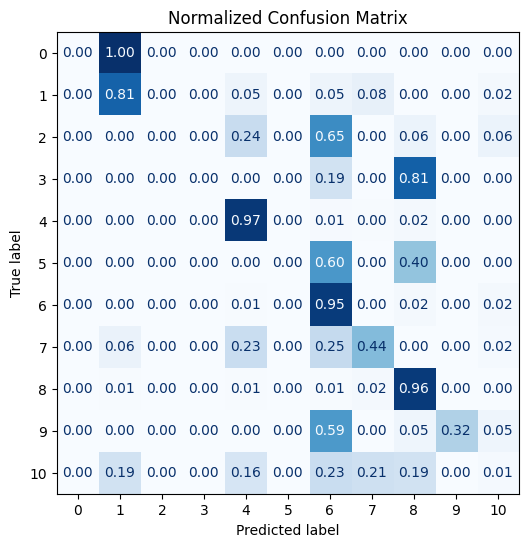

In [52]:
y_preds = np.argmax(preds_output.predictions, axis=1)

plot_confusion_matrix(y_preds, y_valid, labels=[idx for idx, label in enumerate(labels)])

In [54]:
# create a dictionary with the labels as values and their index as keys
label2id = { label: idx for idx, label in enumerate(labels) }
label2id

{'Energy & Utilities': 0,
 'Human Resources': 1,
 'Logistics': 2,
 'Manufacturing': 3,
 'Professional Services': 4,
 'R&D Equipment': 5,
 'Real Estate & Facilities': 6,
 'Sales, Marketing & Events': 7,
 'Technology/Telecom': 8,
 'Travel & Expense': 9,
 'Uncategorized': 10}

## 4.3 Error analysis

A simple technique is to sort the validation samples by the model loss. When the label is passed during the forward pass, the loss is automatically calculated and returned. The goal of this exercise is to detect *wrong labels* or *quirks of the dataset*.

With this information we can refine the dataset, which might be either mislabeled or require a new class altogether. This often can lead to as big a performance gain (or more) as having more data or larger models.

Deep learning models are exceptionally good at finding and exploiting shortcuts to get to a prediction. For this reason, it is also worth investigating the predictions the model is most confident about, so to check if the model is not improperly exploiting random features in the text.

In [55]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # place all input tensors on the device
  inputs = { k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names }

  # forward pass
  with torch.inference_mode():
    model.to(device)
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

  # place output on CPU for compatibility with other dataset columns
  return { "loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy() }

In [56]:
# convert dataset back to PyTorch tensors
data_encoded.with_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# compute loss values
data_encoded["validation"] = data_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map: 100%|██████████| 1690/1690 [00:48<00:00, 34.91 examples/s]


In [57]:
data_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = data_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(lambda row: data["train"].features["label"].int2str(row))

In [58]:
# data samples with highest losses
pd.set_option('display.max_colwidth', None)
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
893,"Normalized Supplier Name, ECOLAB, Country Name, Brazil, Strategic Region, NORAM, Requestor Name, Lisandro Ulerio, Preparer Name, Victória Simonato, Business Unit, Facilities, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), Non-Bay Area Facilities & Operations Group, Cost Center (Level 4), FCS G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Kitchen, Invoice Source, CAFEPRO, GL Description, Kitchen, Project, 31311 - Sao Paolo Aguas de Marco",Human Resources,6,5.146794
581,"Normalized Supplier Name, WEW IMPORTACAO E EXPORTACAO LTDA, Country Name, Brazil, Strategic Region, NORAM, Requestor Name, Lisandro Ulerio, Preparer Name, Victória Simonato, Business Unit, Facilities, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), Non-Bay Area Facilities & Operations Group, Cost Center (Level 4), FCS G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Kitchen, Invoice Source, CAFEPRO, GL Description, Kitchen, Project, 31311 - Sao Paolo Aguas de Marco",Logistics,6,5.145047
354,"Normalized Supplier Name, BRIGAGAO DUQUE ESTRADA ADVOGADOS, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, Rafael Benevides, Preparer Name, Rafael Benevides, Business Unit, Finance, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), Tax Group, Cost Center (Level 4), Finance G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Audit and tax services, Invoice Source, LETTERBOX, GL Description, Audit and tax services, Project, 00000 - Default Project",Uncategorized,4,4.738184
1322,"Normalized Supplier Name, LENOVO TECNOLOGIA BRASIL LIMITADA, Country Name, Brazil, Strategic Region, NORAM, Requestor Name, Stephen Murphy, Preparer Name, ERIKA BOVO, Business Unit, IT & Corpnet, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), EE Ops Supply Chain Group, Cost Center (Level 4), Enterprise Engineering G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Fixed Assets - Gross, Invoice Source, LETTERBOX, GL Description, Assets clearing-capitalized, Project, 00000 - Default Project",R&D Equipment (incl. Equipment Services and Supplies),8,4.605190
360,"Normalized Supplier Name, DIOGO RAIS RODRIGUES MOREIRA, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Legal, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), NORAM Litigation Group, Cost Center (Level 4), Legal G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Legal - litigation, Invoice Source, LETTERBOX, GL Description, Legal - litigation, Project, 00000 - Default Project",Uncategorized,4,4.482581
943,"Normalized Supplier Name, DIOGO RAIS RODRIGUES MOREIRA, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Legal, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), NORAM Litigation Group, Cost Center (Level 4), Legal G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Legal - litigation, Invoice Source, LETTERBOX, GL Description, Legal - litigation, Project, 00000 - Default Project",Uncategorized,4,4.482581
942,"Normalized Supplier Name, D CONTADORES SAC, Country Name, Peru, Strategic Region, LATAM, Requestor Name, Juliana Nelia do Nascimento Correa, Preparer Name, Juliana Nelia do Nascimento Correa, Business Unit, Finance, Legal Entity, Edge Network Services Peru S.A., Cost Center (Base Level), DO NOT USE - Finance Outsourcing Strategy, Cost Center (Level 4), Finance G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Outsourced Services, Invoice Source, OCR, GL Description, Outsourced Services, Project, 82212 - Finance Outsourcing Knowledge Process","Sales, Marketing & Events",4,4.456293
719,"Normalized Supplier Name, COMPAN

In [59]:
# data samples with lowest losses
pd.set_option('display.max_colwidth', None)
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1689,"Normalized Supplier Name, BANCO DO BRASIL S A, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Legal, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), NORAM Litigation Group, Cost Center (Level 4), Legal G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Legal - settlements, Invoice Source, Manual Invoice Entry, GL Description, Legal - settlements, Project, 00000 - Default Project",Professional Services,4,0.024522
945,"Normalized Supplier Name, BANCO DO BRASIL S A, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Legal, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), NORAM Litigation Group, Cost Center (Level 4), Legal G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Legal - settlements, Invoice Source, Manual Invoice Entry, GL Description, Legal - settlements, Project, 00000 - Default Project",Professional Services,4,0.024522
949,"Normalized Supplier Name, BANCO DO BRASIL S A, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Legal, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), NORAM Litigation Group, Cost Center (Level 4), Legal G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Legal - settlements, Invoice Source, Manual Invoice Entry, GL Description, Legal - settlements, Project, 00000 - Default Project",Professional Services,4,0.024522
951,"Normalized Supplier Name, BANCO DO BRASIL S A, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Legal, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), NORAM Litigation Group, Cost Center (Level 4), Legal G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Legal - settlements, Invoice Source, Manual Invoice Entry, GL Description, Legal - settlements, Project, 00000 - Default Project",Professional Services,4,0.024522
954,"Normalized Supplier Name, BANCO DO BRASIL S A, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Legal, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), NORAM Litigation Group, Cost Center (Level 4), Legal G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Legal - settlements, Invoice Source, Manual Invoice Entry, GL Description, Legal - settlements, Project, 00000 - Default Project",Professional Services,4,0.024522
956,"Normalized Supplier Name, BANCO DO BRASIL S A, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Legal, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), NORAM Litigation Group, Cost Center (Level 4), Legal G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Legal - settlements, Invoice Source, Manual Invoice Entry, GL Description, Legal - settlements, Project, 00000 - Default Project",Professional Services,4,0.024522
960,"Normalized Supplier Name, BANCO DO BRASIL S A, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Legal, Legal Entity, Facebook Servicos Online Do Brasil Ltda, Cost Center (Base Level), NORAM Litigation Group, Cost Center (Level 4), Legal G&A, Cost Center (Level 5), General & Administrative, GL Desc (Level 4), Legal - settlements, Invoice Source, Manual Invoice Entry, GL Description, Legal - settlements, Project, 00000 - Default Project",Professional Services,4,0.024522
968,"Normalized Supplier Name, BANCO DO BRASIL S A, Country Name, Brazil, Strategic Region, LATAM, Requestor Name, unknown, Preparer Name, unknown, Business Unit, Legal, Legal Entity, Fa

# References

[Natural Language Processing with Transformers, Chapter 1, L. Tunstall et al.](https://www.amazon.com/Natural-Language-Processing-Transformers-Revised/dp/1098136799)

[A recipe for training neural networks - Andrej Karpathy](http://karpathy.github.io/2019/04/25/recipe/)

[The most common neural net mistakes - Andrej Karpathy @ Twitter](https://twitter.com/karpathy/status/1013244313327681536?lang=en)

[Yes you should understand backprop - Andrej Karpathy](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)